To begin, we need to import PyTorch libraries. The components are can be thought at 2 part. The first part is corresponds to components that related to dataset loading. DataLoader, datasets and transforms are used component here. DataLoader and datasets are helping us to get dataset effectively by using optimized features. The transforms library used for data augmentation.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The torch.manuel_seed() function used for getting same result in each run of code which increases reproducibility. 

In [2]:
torch.manual_seed(42)

The torchvision.transforms used for data augmentation which helps the model to learn better and prevent overfitting. To do it, I used transforms.Compose() function which helps us to run all of transforms by once, which basically a pipeline.

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128 to make training faster
    transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip with 50% probability
    transforms.RandomRotation(degrees=30), # Random rotation with 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # ColorJitter manipulates images based on hsv color space
    transforms.RandomCrop(128, padding=16), # Randomly crop images with padding of 16 pixels
    transforms.RandomGrayscale(p=0.2), # Randomly convert images to grayscale with 20% probability
    transforms.RandomAffine(degrees=10, shear=10), # By preserving parallel lines, affine transformation is applied to images
    transforms.ToTensor(), # Convert images to tensors to work with.
])

We transformed training images, however we don't do it with test dataset, so only using Resize, ToTensor and Normalize functions

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

The first thing to do, assign training dataset to "dataset" variable by using torchvision.datasets.ImageFolder() function. This function help us to assign folder names to class names and assign each of image to corresponding class. The root parameter used for folder path. Example usage is like this: 

> root
- > > dog
- > > > img1
- > > > img2
- > > cat
- > > > img1
- > > > img2
- > > ..

In [5]:
dataset = datasets.ImageFolder(root='train')

I assign the class names to labels parameter which I will use it to randomly split dataset to train and test. For doing it, I used dataset.targets function

In [6]:
labels = dataset.targets

For random split, I used sklearn.model_selection.train_test_split() function. Which is popular choice to split data.

In [7]:
from sklearn.model_selection import train_test_split

The return of train_test_split gives us train and test indices. The inside of train_test_split function takes the indices for data, which is 0 to 6500. I gave 0.2 for test size. The stratify parameter ensures that each of class has %80 train and %20 test split. And the random_state for reproducibility.

In [8]:
train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,  # 20% for test
    stratify=labels,  # Ensure class proportions are maintained
    random_state=42  # For reproducibility
)

Now I have the indices, the next thing I will do it getting subset of original dataset. This subsets will based on train_indices and test_indices. For doing it, I used torch.utils.data.Subset() function.

In [9]:
len(train_indices)

5200

In [10]:
len(test_indices)

1300

In [11]:
from torch.utils.data import Subset

In [12]:
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

Now, train and test dataset are ready to use. Before doing it, I applied transform function that I created early on.

In [13]:
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

Last thing is load datasets by using DataLoader() function. Inside of this, I gave batch_size which tell how many images should be given to model at each run. Shuffle used for give images random order and num_workers for better model performance.

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

After the preprocess step is done, the next step is creating Convolutional Neural Network. 

The cnn structure is init block and forward block. Inside of this two function we can do whatever sequence that we want. The model has 4 conv2d layer, max pooling after 2 conv2d layer ran, activation functions after each conv2d layer and batch normalization. 

To make code cleaner, I used torch.nn.Sequential function which helps us to run each of layer sequentially. 

### Conv2d takes input, generally rgb so it will be 3, and results with feature map. The feature map size is user choice.

### BatchNorm2d normalize the results after each feature map. The value of inside of it corresponds to input size.

### ReLU activation function makes everything 0, if the value is 0 or lower and value itself, if it is larger than 0.

### MaxPool2d is basically selecting max value inside of it matrix. For my example, it corresponds to 2x2 matrices.

self.classifier function is final step for cnn. It connects the feature maps, creating new layers and classify input based on results.

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 20, 3), # 128 - 3 + 1 = 126, After each convolution, the size of the image is reduced by 2 pixels
            nn.BatchNorm2d(20), # Normalize the output of the convolutional layer
            nn.ReLU(), # Activation function
            nn.Conv2d(20, 40, 3), # 126 - 3 + 1 = 124, Again the size of image is reduced by 2 pixels
            nn.BatchNorm2d(40), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 124 / 2 = 62, Max pooling reduces the size of the image by half
            nn.Conv2d(40, 80, 3), # 62 - 3 + 1 = 60
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.Conv2d(80, 160, 3), # 60 - 3 + 1 = 58
            nn.BatchNorm2d(160),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 58 / 2 = 29
        )
        self.classifier = nn.Sequential(
            nn.Linear(160, 200), # We gave 160 as input because adaptive_avg_pool2d will return 160 features
            nn.ReLU(), # Activation function
            nn.Dropout(0.5), # Randomly drop 50% of the connections, which helps to prevent overfitting
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10) # Because we have 10 classes, the last layer has 10 neurons
        )
    # Forward pass
    def forward(self, x):
        x = self.features(x) # Extract features
        x = F.adaptive_avg_pool2d(x, (1, 1)) # Average pooling, the size of the image is reduced to 1x1
        x = torch.flatten(x, 1) # Flatten the output of the convolutional layers
        x = self.classifier(x) # Classify the image
        return x # Return the output

After CNN, we ready to classify images. To faster training, assign the model to cude, if it is possible.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
cnn = CNN().to(device)

To train model, we need to create criterion for loss function. Also optimizer to helping the model. For this one, I choosed the Adam optimizer with learning rate of 0.001. Because of large number of images, choosing small learning rate will lead to better results.

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

To usability, I created training function which takes model and epoch as input.

Inside of function, I ran training loop as given number of epoch.

In [19]:
def train_the_model(cnn, epoch):
    """ 
    cnn : CNN model
    epoch : Number of epochs

    This function trains the model with the given number of epochs.
    """
    # Loop over the dataset as given epoch.
    for epoch in range(epoch):
        # We set running loss as 0.0 for each epoch.
        running_loss = 0.0
        # Enumerate over the train dataloader.
        for i, data in enumerate(train_dataloader, 0):
            # Get the inputs and labels from the dataloader.
            inputs, labels = data
            # Assign each of them to device.
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Optimize the model with the loss function.
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get running loss
            running_loss += loss.item()
        # Calculate the average loss for each epoch.
        epoch_loss = running_loss / len(train_dataloader)
        # Print the average loss for each epoch.
        print(f'Epoch [{epoch+1}/100], Average Loss: {epoch_loss:.4f}')

After everything, we are ready to train our model. After all test I made, train the model with 100 epoch will lead good result.

In [20]:
epoch = 100

In [21]:
train_the_model(cnn, epoch)

Epoch [1/100], Average Loss: 2.0544
Epoch [2/100], Average Loss: 1.8886
Epoch [3/100], Average Loss: 1.7860
Epoch [4/100], Average Loss: 1.7345
Epoch [5/100], Average Loss: 1.6605
Epoch [6/100], Average Loss: 1.6026
Epoch [7/100], Average Loss: 1.5329
Epoch [8/100], Average Loss: 1.5246
Epoch [9/100], Average Loss: 1.4723
Epoch [10/100], Average Loss: 1.4070
Epoch [11/100], Average Loss: 1.3621
Epoch [12/100], Average Loss: 1.3295
Epoch [13/100], Average Loss: 1.2732
Epoch [14/100], Average Loss: 1.2401
Epoch [15/100], Average Loss: 1.1985
Epoch [16/100], Average Loss: 1.1740
Epoch [17/100], Average Loss: 1.1428
Epoch [18/100], Average Loss: 1.1163
Epoch [19/100], Average Loss: 1.0992
Epoch [20/100], Average Loss: 1.1006
Epoch [21/100], Average Loss: 1.0892
Epoch [22/100], Average Loss: 1.0484
Epoch [23/100], Average Loss: 1.0397
Epoch [24/100], Average Loss: 1.0269
Epoch [25/100], Average Loss: 1.0002
Epoch [26/100], Average Loss: 0.9811
Epoch [27/100], Average Loss: 0.9605
Epoch [28/

To see how our model performed, I created function called get_scores. Inside of it, it shows accuracy of our model. Again, it takes model as input.

In [22]:
def get_scores(model):
    # Get class labels
    classes = list(train_dataset.dataset.class_to_idx.keys())
    # Initialize the correct and total predictions
    correct_prediction = 0
    total_prediction = 0
    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Because we are not evaluating the model, we need to use torch.no_grad() function.
    with torch.no_grad():
        # Get the data from the test dataloader
        for data in test_dataloader:
            # Get images and labels and assign it to device
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Predict the images
            outputs = model(images)

            # Get the maximum value of the predictions
            _, predictions = torch.max(outputs, 1)

            # Collect the correct predictions for each class
            total_prediction += labels.size(0)
            correct_prediction += (predictions == labels).sum().item()

            # Assign the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label.item()]] += 1
                total_pred[classes[label.item()]] += 1

    # Print the accuracy of cnn.
    print(f'Accuracy of the network on the {total_prediction} test images: {100 * correct_prediction / total_prediction:.2f} %')
    
    # Print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Run the function to see how model performed.

In [23]:
get_scores(cnn)

Accuracy of the network on the 1300 test images: 73.77 %
Accuracy for class: collie is 76.9 %
Accuracy for class: dolphin is 89.2 %
Accuracy for class: elephant is 76.2 %
Accuracy for class: fox   is 57.7 %
Accuracy for class: giant+panda is 86.9 %
Accuracy for class: moose is 71.5 %
Accuracy for class: polar+bear is 87.7 %
Accuracy for class: rabbit is 50.8 %
Accuracy for class: sheep is 76.9 %
Accuracy for class: squirrel is 63.8 %


After the results, we can look at confusion matrix to how predictions are made. For doing it, I created another function to give us the confusion matrix.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [25]:
def get_confusion_matrix(model):
    # Get class labels.
    classes = list(train_dataset.dataset.class_to_idx.keys())
    # Initialize truelabels and prediction.
    truelabels = []
    predictions = []

    # Get the data from test dataloader.
    for data, target in test_dataloader:
        # Assign each of them to device.
        data, target = data.to(device), target.to(device)

        # Get true label for each of class and assign it to truelabels list.
        for label in target.data.cpu().numpy():
            truelabels.append(label)
        # Make predictions for each of class.
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        # Assign each of prediction to predictions list.
        for prediction in predicted.cpu().numpy():
            predictions.append(prediction)
    
    # Create confusion matrix from sklearn.metrics.
    cm = confusion_matrix(truelabels, predictions)
    # Create
    tick_marks = np.arange(len(classes))
    # Create data frame by using confusion matrix.
    df_cm = pd.DataFrame(cm, index = classes, columns = classes)
    # Creating figure
    plt.figure(figsize = (7,7))
    # Creating heatmap. 
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
    # Adding labels.
    plt.xlabel("Predicted Shape", fontsize = 20)
    plt.ylabel("True Shape", fontsize = 20)
    plt.show()
    

Run the confusion matrix function to see how our model performed.

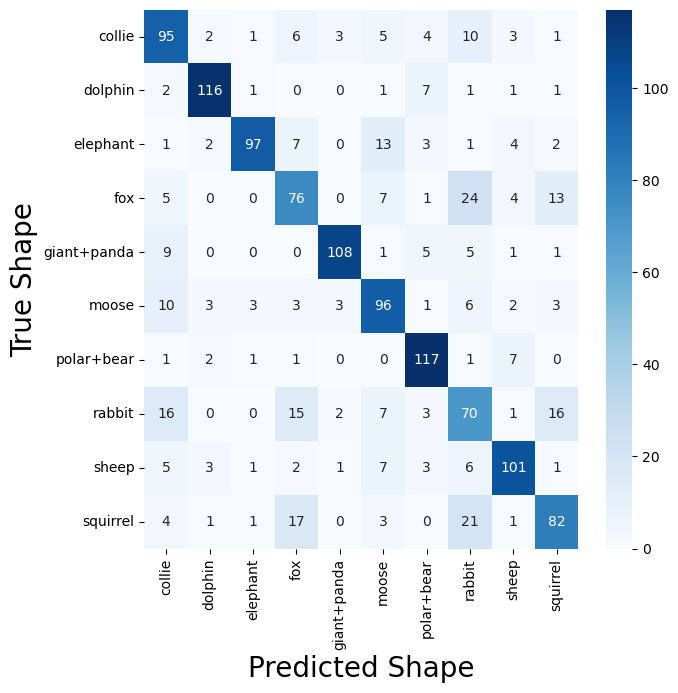

In [26]:
get_confusion_matrix(cnn)

After everything, we need to save our model to use it further, or continue to training.

In [27]:
save_path = "cnn_trained.pth"

In [28]:
torch.save({
        'epoch': epoch,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_path)

To work with different types, we need to save train and test samples in a file since we need them later.

In [29]:
torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')

Now we can manipulate test dataset to see how our model perform in different image manipulation techniques.